## 1) Supposons que je lis le document numéro '422908' dans ma matrice. Appliquez l'algorithme Page rank pour déterminer les autres lectures recommandées. En plus de la simple recommandation des références de '422908', appliquez au moins une variation de cette approche de base, comme celle exposée en classe qui consiste à étendre le sous-ensemble S (références) à S' (références des références). Expliquez la démarche que vous avez prise.

Dans un premier temps on extrait la matrice :

In [1]:
m = as.matrix(read.table("./citeseer.rtable"))

On va réutiliser les fonctions de cosinus de la correction du TP1 :

In [2]:
## Cosinus entre un vecteur v et chaque colonne dela matrice m
cosinus.vm <- function(v,m) { n <- sqrt(colSums(m^2)); (v %*% m)/(n * sqrt(sum(v^2))) }
## Cosinus des colonnes d'une matrice
cosinus.mm <- function(m) { n <- sqrt(colSums(m^2)); crossprod(m)/(n %o% n) }
# Trouve les indexes des premières 'n' valeurs maximales d'une matrice
max.nindex <- function(m, n=5) {
  i <- order(m, decreasing=TRUE)
  return(i[1:n])
}
min.nindex <- function(m, n=5) {
  i <- order(m)
  return(i[1:n])
}

Une première solution serait tout simplement de faire tourner l'algorithme PageRank basique (sans variations) et ensuite de recommander les articles ayant le plus haut score (donc les plus populaires). Nous avons choisis $d = 0.85$ car c'est une valeur courante pour cet algorithme.

In [3]:
PageRank <- function(m,d){
  A = as.matrix(m)
  n = nrow(m)
  R = matrix(1.0,1,n)
  s = rowSums(m) + 1
  oldR = matrix(0.0,1,n)
  i = 0
  while (norm(R-oldR) > 0.0001){
    oldR = R
    R = (1-d)/n + d*(R/s)%*%A
    i = i + 1
  }
  print("Nombre d'itérations : ")
  print(i)
  return(R)
}

GlobalRank <- PageRank(m,0.85)
Recommendations1 <- rownames(m)[order(GlobalRank, decreasing=TRUE)[1:10]]
format(Recommendations1)

[1] "Nombre d'itérations : "
[1] 21


[1] "311874" "19422 " "17094 " "70445 " "422908" "28887 " "245669" "206738"
 [9] "225173" "155792"

Mais cette solution ne prend pas en compte le fait que le document numéro '422908' a été lu : cela revient à calculer la
probabilité qu’un individu lit un certain article suite à une navigation aléatoire.

Nous avons donc implémenté un algorithme PageRank personnalisé : 

Au lieu d'avoir un vecteur PageRank initialisé à 1 pour tous les articles, seul le document lu sera initialisé à 1 tandis que les autres seront à 0. De plus, il n'y a plus de possibilité de _téléportation_ : en effet, le facteur $(1-d)/n$ n'est plus présent lors dans les itérations. À la place, la variable $a \in [0;1]$ représente la probabilité que l'utilisateur reste sur l'article actuel (il ne navigue pas vers un des autres documents référencés).

In [4]:
personnalize_PageRank <- function(m,a,document_number,number_of_recommendations){
  index = grep(document_number, rownames(m), ignore.case=T)
  A = as.matrix(m)
  n = nrow(m)
  R = matrix(0.0,1,n)
  R[1,index] = 1.0
  s = t(rowSums(m) + 1)
  oldR = matrix(0.0,1,n)
  i = 0
  while (norm(R-oldR) > 0.0001){
    oldR = R
    R = a * R + (1-a)*(R/s)%*%A
    i = i + 1
  }
  print("Nombre d'itérations : ")
  print(i)
  recommendations <- order(R, decreasing=TRUE)[1:number_of_recommendations]
  return(rownames(m)[recommendations])
}

Recommendations2 <- personnalize_PageRank(m,0.15,422908,10)
format(Recommendations2)

[1] "Nombre d'itérations : "
[1] 20


[1] "70445 " "17094 " "155792" "64835 " "315693" "396568" "110303" "149820"
 [9] "522428" "389559"

Une troisième possibilité est de mêler la popularité globale des documents (calculées par le PageRank classique) avec la valeur de similarité entre le document lu et les autres. Pour se faire, la valeur finale de recommandation d'un document $A$ vaut $ \alpha * PageRank(A) + (1-\alpha) * sim(422908,A)$. Étant donné qu'en moyenne la valeur de similarité était 200 fois plus élevée que celle du PageRank, nous avons choisis $\alpha = 0.995$ afin d'avoir un apport égal entre la popularité et la similarité.

In [5]:
similarity_PageRank <- function(m,d,alpha,document_number,number_of_recommendations){
  R <- PageRank(m,d)
  index <- grep(document_number, rownames(m), ignore.case=T)
  M <- as.matrix(m)
  sim <- cosinus.vm(M[index,],t(M))
  sim[is.na(sim)] <- 0.0
  result <- alpha * R + (1-alpha) * sim
  recommendations <- order(result, decreasing=TRUE)[1:number_of_recommendations]
  return(rownames(m)[recommendations])
}

Recommendations3 <- similarity_PageRank(m,0.85,0.995,422908,10)
format(Recommendations3)

[1] "Nombre d'itérations : "
[1] 21


[1] "311874" "422908" "19422 " "70445 " "17094 " "155792" "96767 " "225173"
 [9] "149673" "466838"

Finalement, nous avons réutiliser ces 3 méthodes mais avec une matrice d'adjacence modifiée : comme conseillé, nous avons étendu l'ensemble des références à celui des références de références via la fonction ci-dessous : 

In [6]:
Extend_references <- function(m){
  M <- as.matrix(m)
  newM <- M + M%*%M
  newM[newM!=0] <- 1.0
  return(newM)
}


bigM <- Extend_references(m)

Pour uniquement le Page Rank:

In [7]:
BigGlobalRank <- PageRank(bigM,0.85)
Recommendations4 <- rownames(bigM)[order(BigGlobalRank, decreasing=TRUE)[1:10]]
format(Recommendations4)

[1] "Nombre d'itérations : "
[1] 23


[1] "311874" "19422 " "225173" "206738" "396568" "70445 " "61863 " "17094 "
 [9] "155792" "64835 "

Pour le Page Rank personalisé:

In [8]:
Recommendations5 <- personnalize_PageRank(bigM,0.85,422908,10)
format(Recommendations5)

[1] "Nombre d'itérations : "
[1] 80


[1] "396568" "70445 " "17094 " "155792" "315693" "64835 " "149820" "389559"
 [9] "110303" "548620"

Pour le Page Rank hybride:

In [9]:
Recommendations6 <- similarity_PageRank(bigM,0.85,0.995,422908,10)
format(Recommendations6)

[1] "Nombre d'itérations : "
[1] 23


[1] "311874" "422908" "64835 " "17094 " "19422 " "70445 " "96767 " "131548"
 [9] "497542" "155792"

## 2) Comparez les résultats obtenus avec une approche basée sur la similarité des articles dans un espace vectoriel, à l'instar du calcul de similarité de l'approche item-item. La mesure de la similarité et la façon de l'utiliser pour estimer la pertinence d'articles similaires est laissé à votre discrétion.

On sélectionne l'index de l'article 422908.
On calcule la distance consinus du vecteur de l'article et de tous les autres articles.
Les articles les plus proches de l'article 422908 seront considéré comme les articles à recommander.

In [10]:
i <- grep('422908', as.character(rownames(m)), ignore.case=T)

sim.cos <- as.vector(cosinus.vm(m[,i], m))
i.sim.cos <- max.nindex(sim.cos)
sim.cos.sorted <- data.frame(Cos=sim.cos[i.sim.cos], Article=as.character(rownames(m)[i.sim.cos]), Index=i.sim.cos)
head(sim.cos.sorted)

Cos,Article,Index
<dbl>,<fct>,<int>
1.0000000,422908,747
0.5212860,96767,1081
0.4445542,496938,858
0.3680374,425638,755
0.3626593,522428,889


## 3) Utilisez une validation croisée pour évaluer la performance de l'approche item-item.

On va utiliser une validation croisée de type leave-one-out. Il s'agit de la version extrème de la K-fold cross validation, où chaque vecteur sera considérer comme un ensemble de test comportant un unique élement. Nous allons donc essayer de prédire chaque vecteur de la matrice.

La première chose à faire est de récupérer chaque distance entre les articles. On se base sur la distance cosinus pour cela.

In [11]:
m.sim.cos = cosinus.mm(m)
head(m.sim.cos)

,X100299,X100967,X10151,X101705,X101863,X102458,X102886,X102966,X10302,X103700,⋯,X96767,X97060,X97150,X9721,X97410,X97863,X98185,X99113,X9947,X9993
X100299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X100967,NaN,1,0,NaN,0,NaN,0,NaN,0,0,⋯,0.0000000,0,NaN,0,0,NaN,0,NaN,0,0
X10151,NaN,0,1,NaN,0,NaN,0,NaN,0,0,⋯,0.0000000,0,NaN,0,0,NaN,0,NaN,0,0
X101705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X101863,NaN,0,0,NaN,1,NaN,0,NaN,0,0,⋯,0.2357023,0,NaN,0,0,NaN,0,NaN,0,0
X102458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On doit maintenant nettoyer un peu nos données. Par exemple la première colonne ne comporte que des NaN, car l'article ne comporte aucune référence vers d'autres articles.

Nous allons donc faire la somme de chaque colone et regarder si la somme des distances est suppérieur à 1. Cela permettra de selectionner seulement les articles qui possède au moins une ressemblance avec un autre article (la distance cosinus à lui même est 1. Si une autre distance à un article est définie alors la somme des distances sera suppérieure à 1).

In [12]:
index.m.sim.cos.noColNa <- which(colSums(m.sim.cos, na.rm = TRUE) > 1)

Une fois les index selectionnés, nous allons créer les matrices de base de notre prédiction:
- une matrice m "propre", ne comportant que les articles intérésant à analyser
- une matrice de prédiction que nous allons remplir avec chaque vecteur prédit
- une matrice comportant les distances cosinus des articles sélectionnés

In [13]:
m.clean <- m[,index.m.sim.cos.noColNa]

m.predicted <- matrix(, nrow=nrow(m.clean), ncol=ncol(m.clean))
rownames(m.predicted) <- rownames(m.clean)
colnames(m.predicted) <- colnames(m.clean)

m.clean.sim.cos <- m.sim.cos[index.m.sim.cos.noColNa,index.m.sim.cos.noColNa]

Un petit test de concepte:
- on sélectionne l'index du plus proche article d'un article en particulier en omettant lui-même

In [14]:
index = 1
index.closest <- max.nindex(m.clean.sim.cos[-index,index], 1)

-  on remplace ce vecteur dans la matrice de prédiction, là où était l'ancien vecteur réel.

In [15]:
m.predicted[,index] <- m.clean[,index.closest]
test.i2 <- data.frame(m.clean[,index], m.predicted[,index])
head(test.i2, 20)

,m.clean...index.,m.predicted...index.
,<int>,<int>
100299,0,0
100967,0,0
10151,0,0
101705,0,0
101863,0,0
102458,0,0
102886,0,0
102966,0,0
10302,0,0


On fait maintenant cela pour tout les articles par index de colone de la matrice

In [16]:
replace_by_closest <- function(index, m.predicted) {
  # on selectionne l'index du plus proche vecteur sans prendre en compte lui même
  index.closest <- max.nindex(m.clean.sim.cos[-index,index], 1)
  m.predicted[,index] <<- m.clean[,index.closest]
}

buffer <-lapply(1:ncol(m.clean), replace_by_closest, m.predicted)
RMSE <- sqrt(mean((m.clean - m.predicted)^2, na.rm=T))
print(RMSE)

[1] 0.07384659


Le problème est qu' un article a en moyenne très peu de citation en commun avec les autres articles (le graph est très peu dense). La valeur de la RMSE est donc biaisée, on ne peut pas prédire efficasement les citations des articles à partir de son plus proche vosisin, car on a trop peu d'articles qui se ressembles.

On va maintenant essayer une autre approche.
Nous allons faire une validation croisée en Leave-one-out sur une citation à la fois plutôt que sur un article au complet
Nous allons retirer une citation d'un article et voir si cette citation fait partie de ses plus proche voisins
En leave-one-out, on essaye simplement sur chaque arrête du graph

Une petite preuve de concepte:
- on selectionne les k plus proche voisins pour un vecteur d'article

In [17]:
# on sélection pour l'index 1 ses k plus proches voisins
index = 2
nombre_de_knn = 5
index.closest <- max.nindex(m.clean.sim.cos[-index,index], nombre_de_knn)

- on selectionne le subset de la matrice m.clean comportant uniquement ces voisins

In [18]:
 head(m.clean[,index.closest])

,X45071,X92901,X130238,X100967,X10151
100299,0,0,0,0,0
100967,0,0,0,0,0
10151,0,0,0,0,1
101705,0,0,0,0,0
101863,0,0,0,0,0
102458,0,0,0,0,0


- le produit matriciel du vecteur de l'article choisi et de la sous matrice de ses plus proches voisins donnera pour chaque vecteur le plus proche son nombre de citation en commun

In [19]:
m.clean[, index] %*% m.clean[,index.closest]

X45071,X92901,X130238,X100967,X10151
0,0,0,0,2


- on détermine l'accuracy de cet exemple en sommant le nombre de citation en commun et en le divisant par le nombre de citation de l'article

In [20]:
# on ne fait pas de controle sur la division par 0
# car la matrice utilisé ne comporte que des articles ayant au moins une citation
sum(m.clean[, index] %*% m.clean[,index.closest])/sum(m.clean[, index])

[1] 1

Nous allons maintenant faire cela pour tout les articles de la même manière que tout à l'heure

In [21]:
get_accuracy_on_vect <- function(index) {
    index.closest <- max.nindex(m.clean.sim.cos[-index,index], nombre_de_knn)
    return(sum(m.clean[, index] %*% m.clean[,index.closest])/sum(m.clean[, index]))
}

acc_vect <-lapply(1:ncol(m.clean), get_accuracy_on_vect)
acc_on_all_knn <- mean(unlist(acc_vect, use.names=FALSE), rm.na=TRUE)


Ici, il s'agit du nombre d'article en commun avec ses plus proches voisins (peut être suppérieur à 1 si une de ses citation figure dans plusieur de ses plus proche voisins)

In [22]:
print(acc_on_all_knn)

[1] 1.525779


En considérant 5 de ces plus proches voisins, un article figure en moyenne 1,5 fois parmis ceux-ci

Ici, il s'agit d'une définition plus proche de la notion de précision que l'on connait. On divise le nombre ci-dessus par le nombre de plus proche voisins considérés. Ce nombre sera donc compris entre 0 et 1

In [23]:
acc_by_knn <- acc_on_all_knn / nombre_de_knn
print(acc_by_knn)

[1] 0.3051558


En moyenne, la probabilité qu'une citation soit commune avec un des 5 plus proches voisins en particulier est 0.3

Nous allons maintenant essayer de trouver k pour lequel l'accuracy par nombre de plus proche voisins est maximal

In [24]:
# on considère jusqu'a 150 plus proches voisins
nombre_de_knn = 50

acc_by_knn_vect <- lapply(1:50, function(nombre_de_knn){
    acc_vect <-lapply(1:ncol(m.clean), function(index) {
        index.closest <- max.nindex(m.clean.sim.cos[-index,index], nombre_de_knn)
        return(sum(m.clean[, index] %*% m.clean[,index.closest])/sum(m.clean[, index]))
    })
    acc_on_all_knn <- mean(unlist(acc_vect, use.names=FALSE), rm.na=TRUE)
    return(acc_on_all_knn / nombre_de_knn)
})
acc_on_all_knn_vect <- lapply(1:50, function(nombre_de_knn){
    acc_vect <-lapply(1:ncol(m.clean), function(index) {
        index.closest <- max.nindex(m.clean.sim.cos[-index,index], nombre_de_knn)
        return(sum(m.clean[, index] %*% m.clean[,index.closest])/sum(m.clean[, index]))
    })
    return(mean(unlist(acc_vect, use.names=FALSE), rm.na=TRUE))
})

On peut voir que l'accuracy par nombre de voisin le plus proche baisse au fur et à mesure qu'on augmente le nombre de voisin.
Cela veut dire que le plus souvent, c'est bien le plus proche voisin qui comporte les articles les plus intéressants.

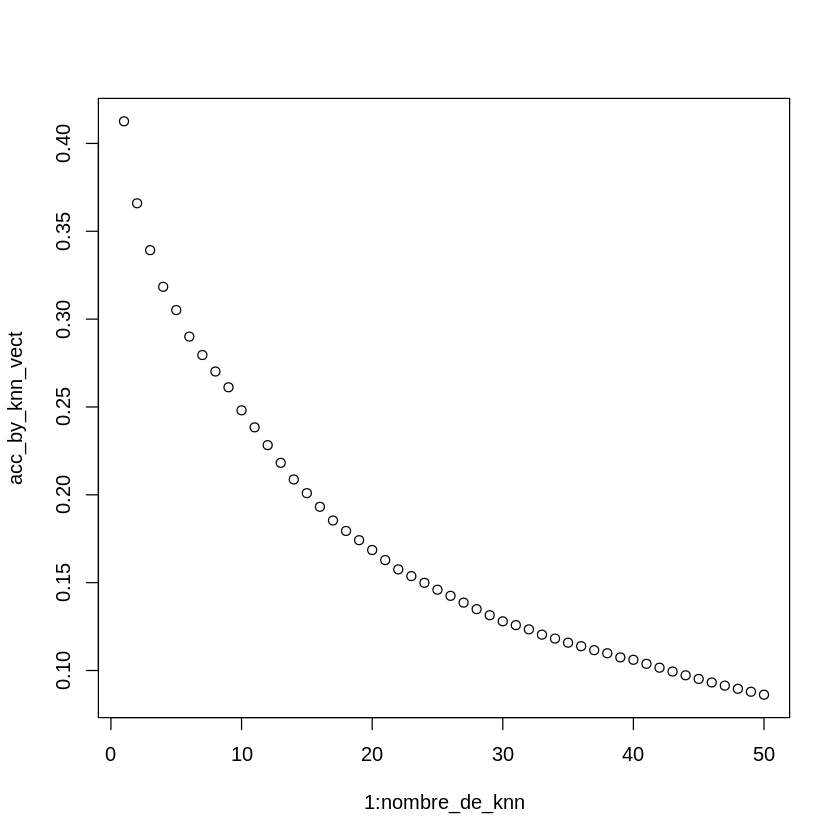

In [25]:
plot(1:nombre_de_knn, acc_by_knn_vect)

Pour information, voila le nombre d'article en moyenne trouvé dans chaque groupe d'article les plus proches

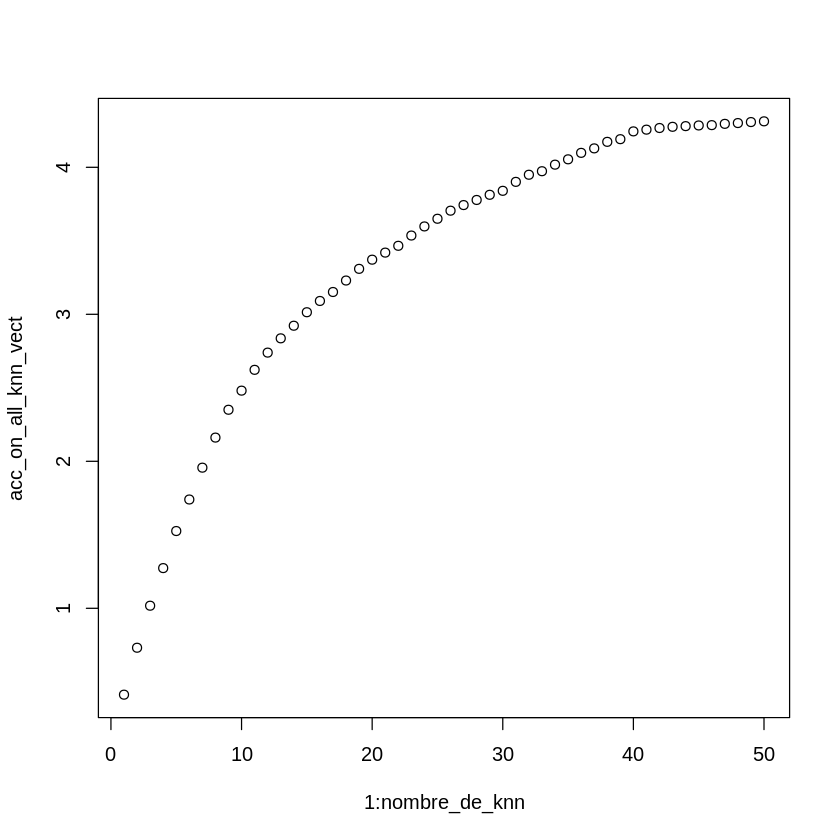

In [26]:
plot(1:nombre_de_knn, acc_on_all_knn_vect)

On peut voir que ce nombre tends vers une valeure finie, un peu suppérieure à 4.

La moyenne des publications par article est d'environ:

In [27]:
mean(colSums(m.clean))

[1] 4.186765

En moyenne, on trouve donc toujours l'article parmis les plus proches articles si on considère tout les articles comme étant proches, ce qui est logique car nous avons retiré les articles n'ayant aucune citation

Ce qui est plus intéressant est que dès 35 voisins considérés, on peut voir qu'en moyenne, la citation considérée se trouvera presque à coup sur parmis les plus proches voisins, car on passe la barre des 4 articles.